In [1]:
include("F:/Tue/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities, Zygote
using DataStructures: Queue, enqueue!, dequeue!
using Flux.Optimise
using CSV, DataFrames

In [2]:
using JLD

In [3]:
include("F:/Tue/Thesis/codes/GP_CVI/normal GP.jl") # remember to change the path 
include("F:/Tue/Thesis/codes/GP_CVI/optimize_normal_GP.jl") # remember to change the path

optim_gp_adam (generic function with 2 methods)

In [4]:
data = CSV.read("F:\\Tue\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";");

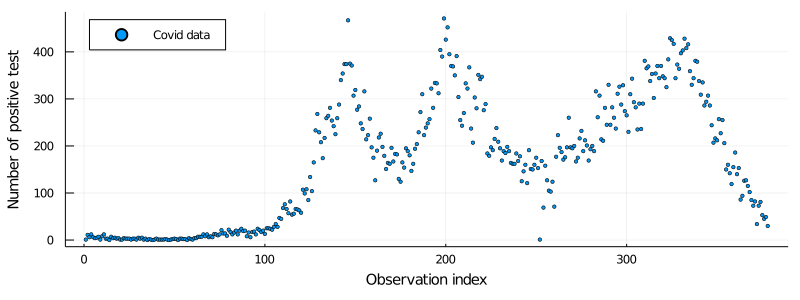

In [5]:
observation = Float64.(data.Tested_positive)
T = length(observation)
scatter(observation, label = "Covid data", legend = :topleft, markersize=2, size = (800, 300), 
    left_margin = 4Plots.mm, bottom_margin = 6Plots.mm, guidefont = 10)
ylabel!("Number of positive test")
xlabel!("Observation index")

In [179]:
savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\covid data.png")

# Model Specification

In [6]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),diagm(0=>ones(2)))
#p_W = Wishart(2,diagm(0=>ones(2)))
W = diagm(0=>ones(2))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

# Inference

In [7]:
# CVI message towards z
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    opt = ADAM(η)
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    violation = 0 # keep track of number of updates lead to invalid parameters 
    λ_m_latest = Queue{Vector}()
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        update!(opt,λ_m,λ_m - grad)
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [40]:
#use normal GP
function filter_GP(W, T)
    #uncertainty_1 = []; #store uncertainty of the 1st element
    #uncertainty_2 = []; #store uncertainty of the 1st element
    #uncertainty_3 = []; #store uncertainty of the 2nd element
    #uncertainty_4 = []; #store uncertainty of the 1st element
    #uncertainty_5 = []; #store uncertainty of the 1st element
    #uncertainty_6 = []; #store uncertainty of the 1st element
    GP_train_size = []; #store the size of training set after updating
    count_new = 0; #count the number of new added observations = number of samples needs cvi
    
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.2,10000);   
    _, _, λ_p, _, _ = exp_family(p_z_init);
    gp_input = vcat(λ_p, observation[1]); #this is our input
    gp_output = λ_m; #this is our output
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    ### Collect the first 25 samples for GP
    for t=2:25
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        #start collecting data for Gp
         _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # use this variable to store new input
        gp_input = hcat(gp_input, temp); # collect new input data for GP
        
        λ_m = approx_message_z(observation[t],predict,0.2,10000);
        gp_output = hcat(gp_output,λ_m); # collect output for GP
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    ### Train GP
    #optimal parameters of the first output element
    σ1_op, l1_op,llh1 = optim_gp(gp_input, gp_output[1,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    σ2_op, l2_op,llh2 = optim_gp(gp_input, gp_output[2,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    #optimal parameters of the third output element
    σ3_op, l3_op,llh3 = optim_gp(gp_input, gp_output[3,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    σ4_op, l4_op,llh4 = optim_gp(gp_input, gp_output[4,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    σ5_op, l5_op,llh5 = optim_gp(gp_input, gp_output[5,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    σ6_op, l6_op,llh6 = optim_gp(gp_input, gp_output[6,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    ### Use GP to predict the rest
    for t=26:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # new point

        λ_m_1,var_1 = gp_predict(gp_input,gp_output[1,:],temp,σ1_op,l1_op); #Predict
        λ_m_2,var_2 = gp_predict(gp_input,gp_output[2,:],temp,σ2_op,l2_op); #Predict
        λ_m_3,var_3 = gp_predict(gp_input,gp_output[3,:],temp,σ3_op,l3_op); #Predict
        λ_m_4,var_4 = gp_predict(gp_input,gp_output[4,:],temp,σ4_op,l4_op); #Predict
        λ_m_5,var_5 = gp_predict(gp_input,gp_output[5,:],temp,σ5_op,l5_op); #Predict
        λ_m_6,var_6 = gp_predict(gp_input,gp_output[6,:],temp,σ6_op,l6_op); #Predict
        
        #uncertainty_1 = append!(uncertainty_1,var_1[1])
        #uncertainty_2 = append!(uncertainty_2,var_2[1])
        #uncertainty_3 = append!(uncertainty_3,var_3[1])
        #uncertainty_4 = append!(uncertainty_4,var_4[1])
        #uncertainty_5 = append!(uncertainty_5,var_5[1])
        #uncertainty_6 = append!(uncertainty_6,var_6[1])
        #check uncertainty, if greater than pre-defined threshold, then collect new data
        if var_1[1] >= 1. || var_2[1] >= 1. || var_3[1] >= 1. || var_4[1] >= 1. || var_5[1] >= 1. || var_6[1] >= 1.
            λ_m = approx_message_z(observation[t],predict,0.2,10000); #use CVI
            gp_input = hcat(gp_input,temp); #observe new input
            gp_output = hcat(gp_output,λ_m); #observe new output
            count_new += 1;
            if count_new == 100
                #optimal parameters of the first output element
                σ1_op,l1_op,llh1 = optim_gp_adam(gp_input, gp_output[1,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000) 
                σ2_op,l2_op,llh2 = optim_gp_adam(gp_input, gp_output[2,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000)
                #optimal parameters of the third output element
                σ3_op,l3_op,llh3 = optim_gp_adam(gp_input, gp_output[3,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000)
                σ4_op,l4_op,llh4 = optim_gp_adam(gp_input, gp_output[4,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000)
                σ5_op,l5_op,llh5 = optim_gp_adam(gp_input, gp_output[5,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000)
                σ6_op,l6_op,llh6 = optim_gp_adam(gp_input, gp_output[6,:],2.,
                    [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,25,1000)
                @show t
                count_new = 0;
            end

        else
            λ_m = [λ_m_1[1],λ_m_2[1],λ_m_3[1],λ_m_4[1],λ_m_5[1],λ_m_6[1]]; #use GP's result
        end
        
        GP_train_size = append!(GP_train_size,size(gp_input,2))
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    
    #return forward_estimates,uncertainty_1,uncertainty_2, uncertainty_3, uncertainty_4, uncertainty_5,uncertainty_6, GP_train_size
    return forward_estimates, GP_train_size
end

function filter_CVI(W, T)
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.2,10000)   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))))
        λ_m = approx_message_z(observation[t],predict,0.2,10000)
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m))
    end
    return forward_estimates
end

function smooth(forward_estimates,W, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

### Use GP

In [26]:
@time begin
forward_estimates,uncer1, uncer2, uncer3, uncer4, uncer5, uncer6, training_size = filter_GP(W,T)
#forward_estimates, training_size = filter_GP(W,T)
smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates, W, T)
end
;

t = 220
 81.993405 seconds (300.84 M allocations: 24.455 GiB, 4.31% gc time)


In [44]:
gp_time = [];
for i=1:15
    time1 = @elapsed forward_estimates, training_size = filter_GP(W,T);
    time2 = @elapsed smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates, W, T);
    gp_time = append!(gp_time,time1 + time2);
end

t = 216


### use CVI

In [28]:
@time begin
forward_estimates = filter_CVI(W,T)
smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates, W, T)
end
;

113.649181 seconds (434.71 M allocations: 30.130 GiB, 5.41% gc time)


In [45]:
cvi_time = [];
for i=1:15
    time1 = @elapsed forward_estimates = filter_CVI(W,T);
    time2 = @elapsed smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates, W, T);
    cvi_time = append!(cvi_time,time1 + time2);
end
;

## Show results

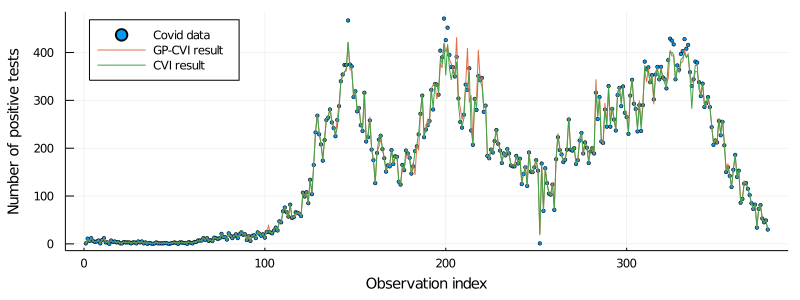

In [34]:
state1_est_GP = zeros(T)
state1_est_CVI = zeros(T)

for t=1:T
    state1_est_GP[t] = mean(smooth_estimates_GP[t])[1]
    state1_est_CVI[t] = mean(smooth_estimates_CVI[t])[1]
end

scatter(observation,markersize=2, size = (800, 300),label = "Covid data")
plot!(exp.(state1_est_GP),label = "GP-CVI result", legend = :topleft, 
    ylabel = "Number of positive tests", xlabel = "Observation index", left_margin = 4Plots.mm, bottom_margin =5Plots.mm,
    guidefont = 10)
plot!(exp.(state1_est_CVI),label = "CVI result")



In [62]:
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\GP_CVI_full.jld","data",state1_est_GP);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\CVI_full.jld","data",state1_est_CVI);

In [35]:
savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\result_test_final.png")

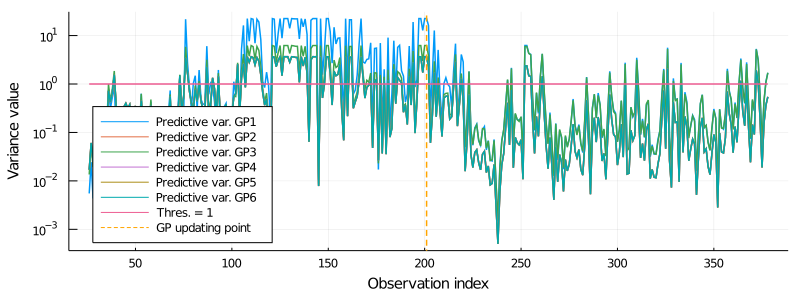

In [36]:
#plot uncertainty of 1st component
plot(26:T,uncer1, label = "Predictive var. GP1", lw = 1.5, yaxis = :log10, size = (800, 300), 
    left_margin = 4Plots.mm, bottom_margin =5Plots.mm, guidefont = 10, legend = :bottomleft)

plot!(26:T,uncer2, label = "Predictive var. GP2", lw = 1.5)

plot!(26:T,uncer3, label = "Predictive var. GP3", lw = 1.5)

plot!(26:T,uncer4, label = "Predictive var. GP4", lw = 1.5)

plot!(26:T,uncer5, label = "Predictive var. GP5", lw = 1.5)

plot!(26:T,uncer6, label = "Predictive var. GP6", lw = 1.5)

plot!(26:T,1 .*ones(length(26:T)),lw = 1.5, label = "Thres. = 1")
plot!([201], seriestype="vline", color = :orange, lw = 1.5, ls = :dash,label = "Re-training point")
ylabel!("Variance value")
xlabel!("Observation index")


In [65]:
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer1_full.jld","uncer",uncer1);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer2_full.jld","uncer",uncer2);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer3_full.jld","uncer",uncer3);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer4_full.jld","uncer",uncer4);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer5_full.jld","uncer",uncer5);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncer6_full.jld","uncer",uncer6);

In [37]:
savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\uncertainty full.png")

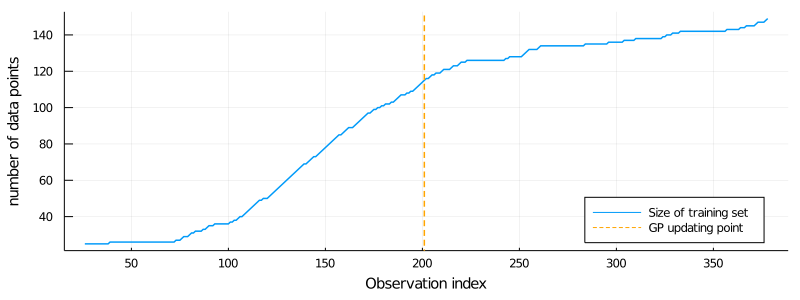

In [38]:
plot(26:T,training_size, legend = :bottomright, lw = 1.5,label = "Size of training set",size = (800, 300),
    left_margin = 4Plots.mm, bottom_margin =5Plots.mm, guidefont = 10)
plot!([201],seriestype="vline", color = :orange, lw = 1.5, ls = :dash,label = "GP updating point")
xlabel!("Observation index")
ylabel!("number of data points")

In [68]:
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\gp_size_full.jld","gpsize",training_size);

In [39]:
savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\progress of updating GP_full.png")

In [32]:
println("Total number of times we use CVI: $(training_size[end]-25)")  #number of times we use CVI

Total number of times we use CVI: 124


In [33]:
println("Total number of times we use GP: $(T - training_size[end])")   #number of times we use GP

Total number of times we use GP: 229


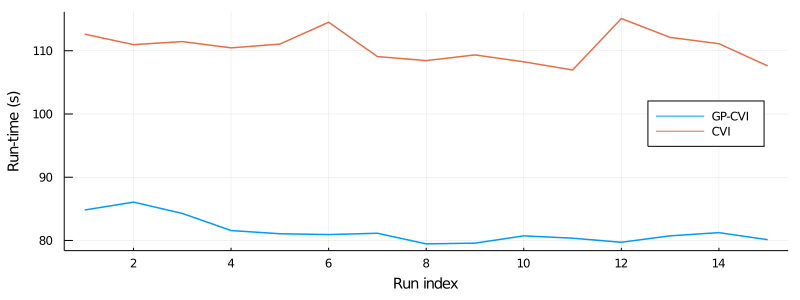

In [46]:
plot(gp_time,label = "GP-CVI",lw=1.5, size = (800, 300),
left_margin = 4Plots.mm, bottom_margin =5Plots.mm, guidefont = 10)
plot!(cvi_time,label = "CVI", lw = 1.5,legend = :right)
xlabel!("Run index")
ylabel!("Run-time (s)")

In [47]:
savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\Time comparison full messa.png")

In [48]:
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\gptime.jld","time",gp_time);
save("F:\\Tue\\Thesis\\codes\\GP_CVI\\cvitime.jld","time",cvi_time);